In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 9.91M/9.91M [00:29<00:00, 339kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 248kB/s]
100%|██████████| 1.65M/1.65M [00:09<00:00, 172kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [10]:
train_data.data.size()
test_data.data.size()

torch.Size([10000, 28, 28])

In [9]:
train_data.targets.size()

torch.Size([60000])

In [14]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data, batch_size=64, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=64, shuffle=True, num_workers=1)
}

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))  
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

In [ ]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders['train'].dataset),
                100. * batch_idx / len(loaders['train']), loss.item()))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(loaders['test'].dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loaders['test'].dataset),
        100. * correct / len(loaders['test'].dataset)))
    

In [27]:
for epoch in range(1, 11):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291111
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.245829
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.004219
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.540129
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.276155
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.231226
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.059892
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.622691
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.734795
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.862072
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.868035
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.612230
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.515028
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.660002
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.534032
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.387175
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.490759
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.476262
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.595608
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.504726
Train Epoch: 1 [

In [28]:
device

device(type='cpu')

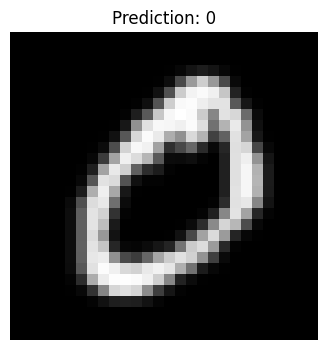

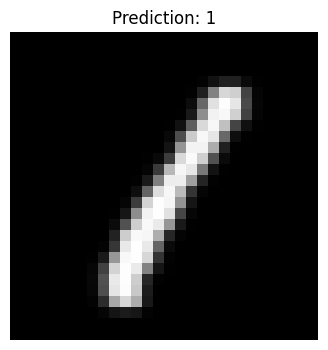

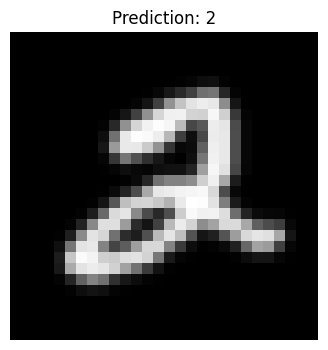

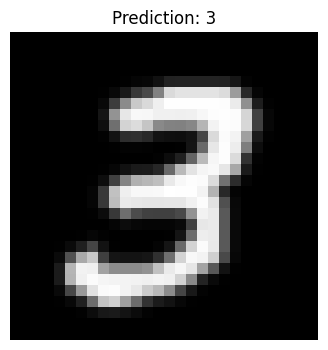

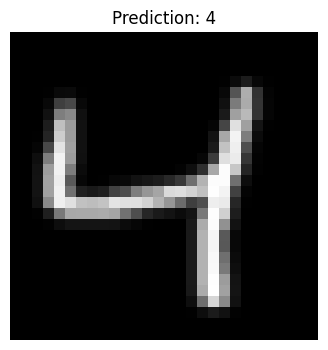

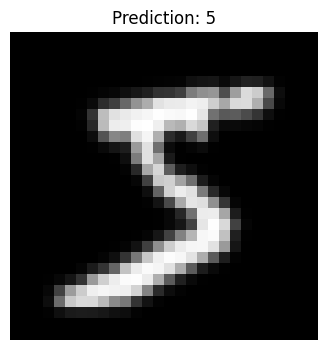

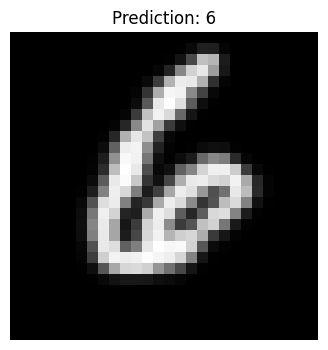

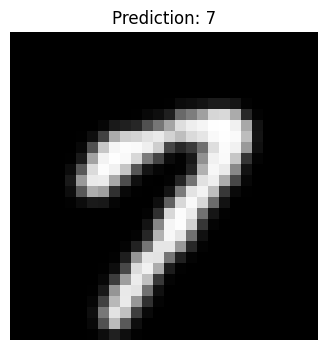

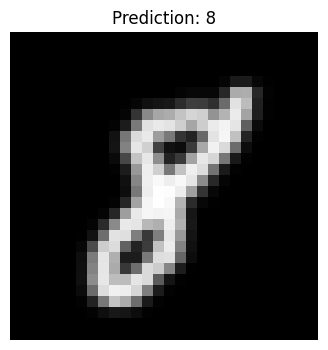

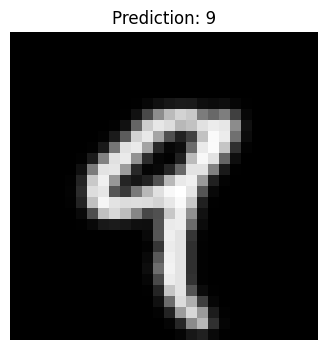

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_custom_image(image_path, transform=None):
    """
    Wczytaj obraz i przygotuj go do predykcji modelu
    
    Args:
    - image_path (str): Ścieżka do pliku obrazu
    - transform (transforms): Transformacje do przekształcenia obrazu
    
    Returns:
    - tensor: Przygotowany obraz do predykcji
    """
    if transform is None:
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  
            transforms.Resize((28, 28)),  
            transforms.ToTensor(),  
            transforms.Normalize((0.1307,), (0.3081,))  
        ])
    
    image = Image.open(image_path)
    image_tensor = transform(image)
    
    return image_tensor

def predict_image(model, image_path, device):
    """
    Przewidaj cyfrę dla podanego obrazu
    
    Args:
    - model: Wytrenowany model CNN
    - image_path (str): Ścieżka do pliku obrazu
    - device: Urządzenie (cuda/cpu)
    
    Returns:
    - int: Przewidziana cyfra
    - numpy.ndarray: Obraz do wyświetlenia
    """
    model.eval()
    data = load_custom_image(image_path)
    data = data.unsqueeze(0).to(device)  
    
    with torch.no_grad():
        output = model(data)
        prediction = output.max(1, keepdim=True)[1]
    
    image = data.cpu().numpy().squeeze()
    
    return prediction.item(), image

def predict_images_in_folder(model, folder_path, device):
    """
    Przewidaj cyfry dla wszystkich obrazów w folderze
    
    Args:
    - model: Wytrenowany model CNN
    - folder_path (str): Ścieżka do folderu z obrazami
    - device: Urządzenie (cuda/cpu)
    """
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} nie istnieje!")
        return
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            try:
                prediction, image = predict_image(model, image_path, device)
                
                # Wyświetl wyniki
                plt.figure(figsize=(4, 4))
                plt.imshow(image.squeeze(), cmap='gray')
                plt.title(f'Prediction: {prediction}')
                plt.axis('off')
                plt.show()
            
            except Exception as e:
                print(f"Błąd przy przetwarzaniu {filename}: {e}")

predict_images_in_folder(model, 'Images/MNIST_Digits/', device)